In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 8.1 MB/s 


In [29]:
from torch.utils.data import Dataset, WeightedRandomSampler
from skimage import io, transform
import os
import pandas as pd
from PIL import Image
import random
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from imageio import imread
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import cm

import pydicom
from abc import ABC, abstractmethod
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A

In [3]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [4]:
print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_FOLDER ='data'
device

__pyTorch VERSION: 1.11.0+cu113
use_cuda = True


'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls "/content/drive/My Drive/medical"


aug.weights		simple_preprocessing.weights  weighted_2.weights
dicom-images-train.zip	train-rle.csv		      weighted_sampling.weights


In [8]:
!cp "/content/drive/My Drive/medical/dicom-images-train.zip" "dicom-images-train.zip"


In [9]:
!cp '/content/drive/My Drive/medical/train-rle.csv' "train-rle.csv"


In [10]:
!ls

dicom-images-train.zip	drive  sample_data  train-rle.csv


In [11]:
!unzip  -q dicom-images-train.zip -d data 


In [12]:
SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)
SEED

999

In [ ]:
# df = pd.read_csv('train-rle.csv', header=None, index_col=0)
# train_fns = sorted(glob.glob('data/dicom-images-train/*/*/*.dcm'))
# len(train_fns)
# df_full = pd.read_csv('train-rle.csv', index_col='ImageId')
# df_full.sample(1)

In [14]:
! ls data

dicom-images-train


In [15]:
train_imgs_paths = sorted(glob.glob('data/dicom-images-train/*/*/*.dcm'))
print("Train images size {}".format(len(train_imgs_paths)))

# test_imgs_paths = sorted(glob('../input/siim-acr-pneumothorax-segmentation-data/dicom-images-test/*/*/*.dcm'))
# print("Test images -", len(test_imgs_paths))
# file_paths = train_imgs_paths + test_imgs_paths

Train images size 10712


In [25]:
# data_df = pd.read_csv('train-rle.csv')
# data_df.rename(columns={" EncodedPixels" : "EncodedPixels"}, inplace=True) # a typo in the csv
# data_df.head()
from collections import defaultdict

rles_df = pd.read_csv('train-rle.csv')
rles_df = rles_df.rename(columns={' EncodedPixels':'EncodedPixels'})
rles_df['EncodedPixels'] = rles_df['EncodedPixels'].apply(lambda x: x.strip())

# Create a dictionary for images with masks
rles_df = rles_df[rles_df['EncodedPixels'] !='-1'].groupby('ImageId')['EncodedPixels'].apply(list).reset_index()
print(len(rles_df))

masks = {}
for index, row in rles_df.iterrows():
    masks[row['ImageId']] = row['EncodedPixels']
print(len(masks))

2379
2379


In [44]:
dataset_rows = []
for image_path in train_imgs_paths:
  id = image_path.split('/')[-1][:-4]
  
  mask = masks[id] if id in masks else None
  dataset_rows.append((id, mask, image_path))

dataset_df = pd.DataFrame(dataset_rows, columns = ['image_id', 'rle', 'image_path'])
dataset_df.sample(3)


,image_id,rle,image_path
2576,1.2.276.0.7230010.3.1.4.8323329.12358.15178752...,[611504 6 1 4 1008 23 998 28 994 30 991 32 988...,data/dicom-images-train/1.2.276.0.7230010.3.1....
7016,1.2.276.0.7230010.3.1.4.8323329.31915.15178751...,[313643 2 1021 3 1018 6 1017 7 1015 9 1013 10 ...,data/dicom-images-train/1.2.276.0.7230010.3.1....
3905,1.2.276.0.7230010.3.1.4.8323329.13573.15178752...,None,data/dicom-images-train/1.2.276.0.7230010.3.1....


In [45]:
X_train_df, X_val_df = train_test_split(dataset_df, test_size=0.1, random_state=SEED)
X_train_df.shape, X_val_df.shape

((9640, 3), (1072, 3))

In [319]:
class ImagesDataset(Dataset):
    def __init__(self, df, image_size = 128, transform = None):
        self.df = df
        self.transform = transform
        self.image_size = image_size
        
      
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        row = self.df.iloc[index]

        X = np.zeros((self.image_size, self.image_size))
        y = np.zeros((self.image_size, self.image_size))

        image_path = row['image_path']

        image = pydicom.read_file(image_path).pixel_array
        image_resized = cv2.resize(image, (self.image_size, self.image_size))
        image_resized = np.array(image_resized, dtype=np.float64)

        

        mask = np.zeros((1024, 1024))

        rle = row['rle']
        if rle is not None:
          for r in rle:
            mask =  mask + rle2mask(r, 1024, 1024).T

        mask_resized = cv2.resize(mask, (self.image_size, self.image_size))

        mask_resized = np.where(mask_resized  > 0, 1, 0)

        if self.transform is not None:
          
          #image_resized = Image.fromarray(image_resized)
          #image_resized = image_resized.convert("L")

          #mask_resized = Image.fromarray(mask_resized.astype('uint8'), 'L')

          #image_resized, mask_resized = self.transform(image_resized, mask_resized)
          #image_resized = self.transform(image_resized)
          transformed = self.transform(image=image_resized, mask=mask_resized)
          image_resized = transformed['image']
          mask_resized = transformed['mask']
          
        return np.expand_dims(image_resized/255.0, 0), np.expand_dims(mask_resized, 0)



In [318]:
# from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ToTensor, ToPILImage
# from torchvision import transforms as T





# torchvision_transform = T.Compose([
#     RandomHorizontalFlip(0.5),
#     RandomVerticalFlip(0.5),
#     RandomRotation(0.3)
# ])

transformations = A.Compose(
    transforms=[
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30)
        ],
    additional_targets={'image0': 'image', 'image1': 'mask'}
)


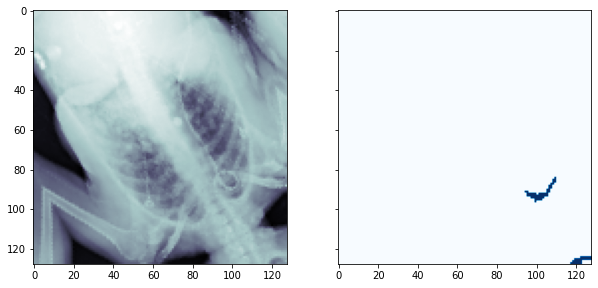

In [324]:
# train_dataset = ImagesDataset(X_train_df, transform = transformations)

# # x, y = train_dataset.__getitem__(7540) 
# # # yf = y.astype(np.float)
# # y = np.squeeze(y, 0)
# # x = np.squeeze(x, 0)

# #fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
# #ax[0].imshow(x,cmap='bone')
# #ax[1].imshow(y,cmap='Blues')

# #torchvision_transform(y)

# # y.shape 
# #ToPILImage()(y.astype(np.float))

# # ii = Image.fromarray(255 * y, '1')
# # # ii
# # np.array(ii).max()
# # PIL_image = Image.fromarray(y.astype('uint8'), 'L')

 
# # torchvision_transform(x, )

# # xx = np.array(PIL_image)

# # fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
# # ax[0].imshow(x,cmap='bone')
# # ax[1].imshow(y,cmap='Blues')




# # transformed = transform1(image=x, image0=y)
# # transformed['image'].shape


# # transformed = transform1(image=x, mask=y)
# # transformed_image = transformed['image']
# # transformed_mask = transformed['mask']

# # transformed_image.shape, transformed_mask.shape 

# fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
# ax[0].imshow(x,cmap='bone')
# ax[1].imshow(y,cmap='Blues')


In [325]:
train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)



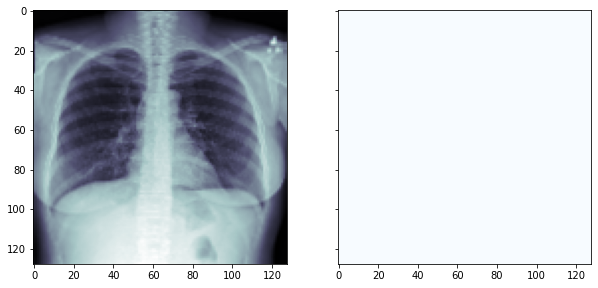

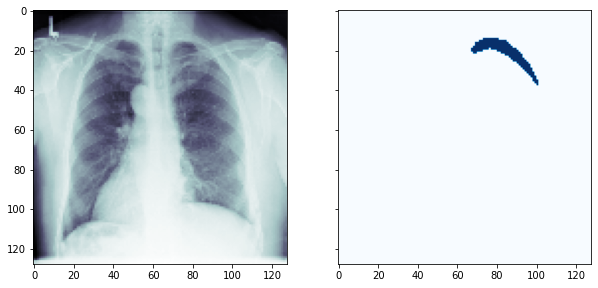

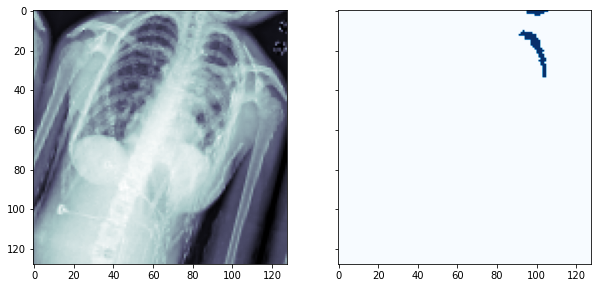

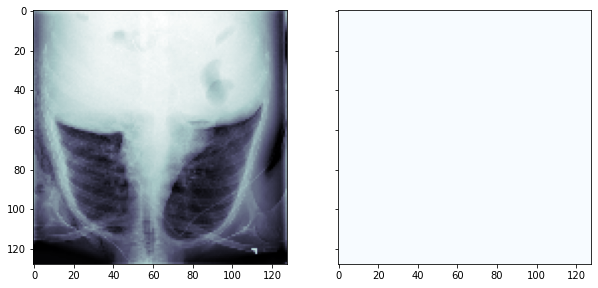

In [328]:
for i in np.random.choice(len(train_dataset), size =4, replace = False):
    x, y = train_dataset.__getitem__(i)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)
    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')
 

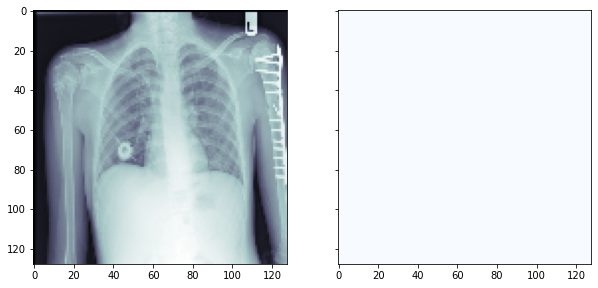

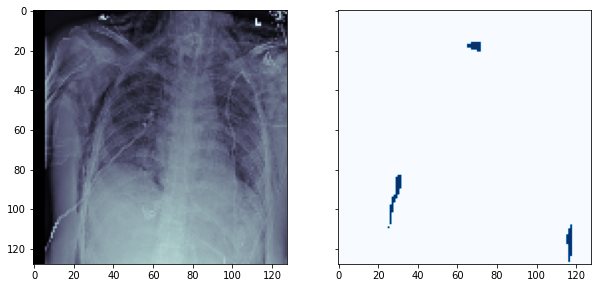

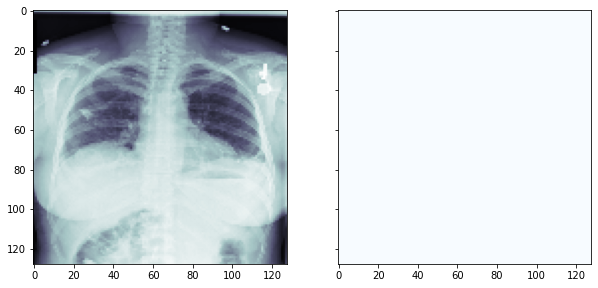

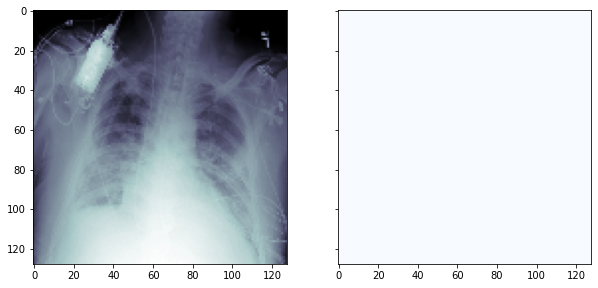

In [330]:

for i in np.random.choice(len(validation_dataset), size =4, replace = False):    
    x, y = validation_dataset.__getitem__(i)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)

    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')

Transformations for the same image

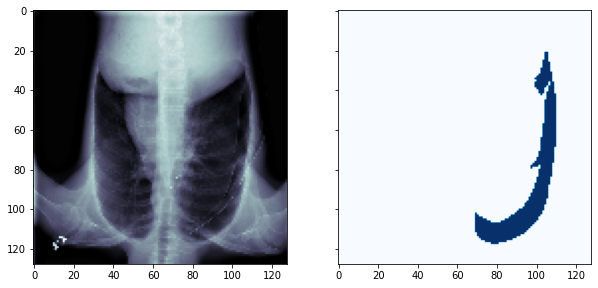

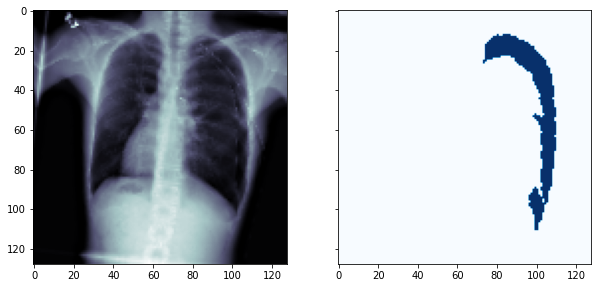

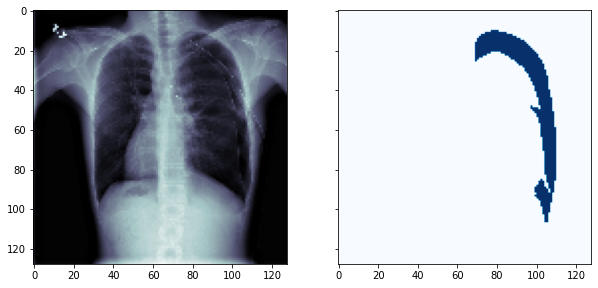

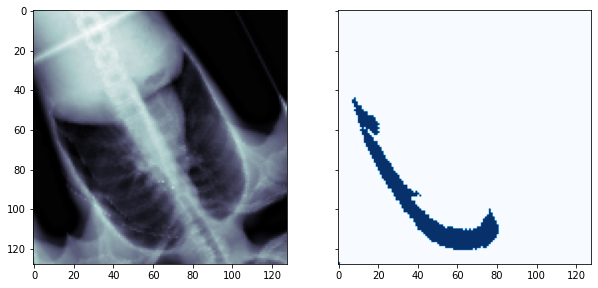

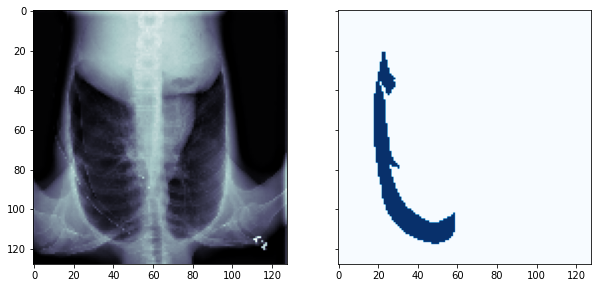

In [335]:
positive_dataset = ImagesDataset(X_train_df[X_train_df['rle'].notnull()], transform = transformations)

image_index = np.random.choice(len(positive_dataset), size =1, replace = False)[0]

for i in range(5):    
    x, y = positive_dataset.__getitem__(image_index)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)

    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')


UNET

In [336]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 128)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        self.down3 = Down(512, 1024)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

losses 

In [337]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [338]:
def train(model, data_loader, optimizer, criterion):
    calc_loss = 0.
    calc_count = 0.

    model.train()

    for images, labels in data_loader:

        calc_count += labels.shape[0]
        images = images.float().to(device)
     
        labels = labels.float().to(device)
        images = Variable(images)
        labels = Variable(labels)

        output = model(images)
        loss = criterion(output, labels)
        calc_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return calc_loss/calc_count


def eval_model(model, data_loader, criterion):
    model.eval()
    
    calc_loss = 0.
    calc_count = 0.
    
    with torch.no_grad():
        for images, labels in data_loader:
            calc_count += labels.shape[0]
            images = images.float().to(device)

            labels = labels.float().to(device)
            images = Variable(images)
            labels = Variable(labels)
            output = model(images)
            loss = criterion(output, labels)
            calc_loss += loss.item()
            
        
    return calc_loss/calc_count

    

In [339]:
def run_experiment(exp_name, model, criterion, optimizer, numer_of_epoch, train_data_loader, validation_data_loader):
    
    min_val_loss = 100000
    weights_path = '/content/drive/My Drive/medical/{}.weights'.format(exp_name)

    for epoch in range(numer_of_epoch):
        print(epoch)
        train_loss = train(model, train_data_loader, optimizer, criterion)
        val_loss = eval_model(model, validation_data_loader, criterion)

        if val_loss < min_val_loss:
          min_val_loss =  val_loss

         
          torch.save(model.state_dict(), weights_path)

        print('epoch {} train loss {} val loss {}'.format(epoch, train_loss, val_loss))

Baseline

In [341]:
# #baseline
model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 50
momentum = 0.9
numer_of_epoch = 3 

criterion =nn.BCEWithLogitsLoss().to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

run_experiment('baseline', model, criterion, optimizer, numer_of_epoch, train_data_loader, validation_data_loader)
# for (x,y) in train_data_loader:
#   break

x.shape #(N,C in,H,W)

0


RuntimeError: ignored

In [142]:
# # for (x,y) in train_data_loader:
# #   break

# x.shape, y.shape

(torch.Size([16, 128, 128]), torch.Size([16, 128, 128]))